In [1]:
import warnings
warnings.filterwarnings("ignore")



In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from shapely.geometry import Point
import pandas as pd
from matplotlib.lines import Line2D
from shapely.ops import nearest_points
from shapely.geometry import Point
from shapely.geometry import LineString
import networkx as nx
import plotly.graph_objects as go



# Suppress warnings
ox.settings.log_console = False
ox.settings.use_cache = True

In [3]:
place = "Islamabad, Pakistan"

boundary = ox.geocode_to_gdf(place)
gdf_utm = gpd.read_file("preprocessedData/utm_point.gpkg")
utm_crs = gdf_utm.crs
print("UTM CRS:", utm_crs)

UTM CRS: EPSG:32643


In [4]:
all_pois = gpd.read_file("preprocessedData/all_pois.gpkg", layer='pois')
G = ox.load_graphml("preprocessedData/network.graphml")
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
major_roads = edges[edges['highway'].isin(['primary', 'secondary', 'trunk'])]


In [5]:
# Project all data to UTM
boundary = boundary.to_crs(utm_crs)
all_pois = all_pois.to_crs(utm_crs)
G = ox.project_graph(G, to_crs=utm_crs)


In [6]:
metro_routes = gpd.read_file('metro-data/islamabad_sections.geojson').to_crs(utm_crs)
metro_service_areas = gpd.GeoDataFrame(geometry=metro_routes.buffer(500), crs=utm_crs)


In [7]:
population = gpd.read_file("preprocessedData/population_clusters.gpkg")
stations = gpd.read_file("preprocessedData/snapped_stations.gpkg")


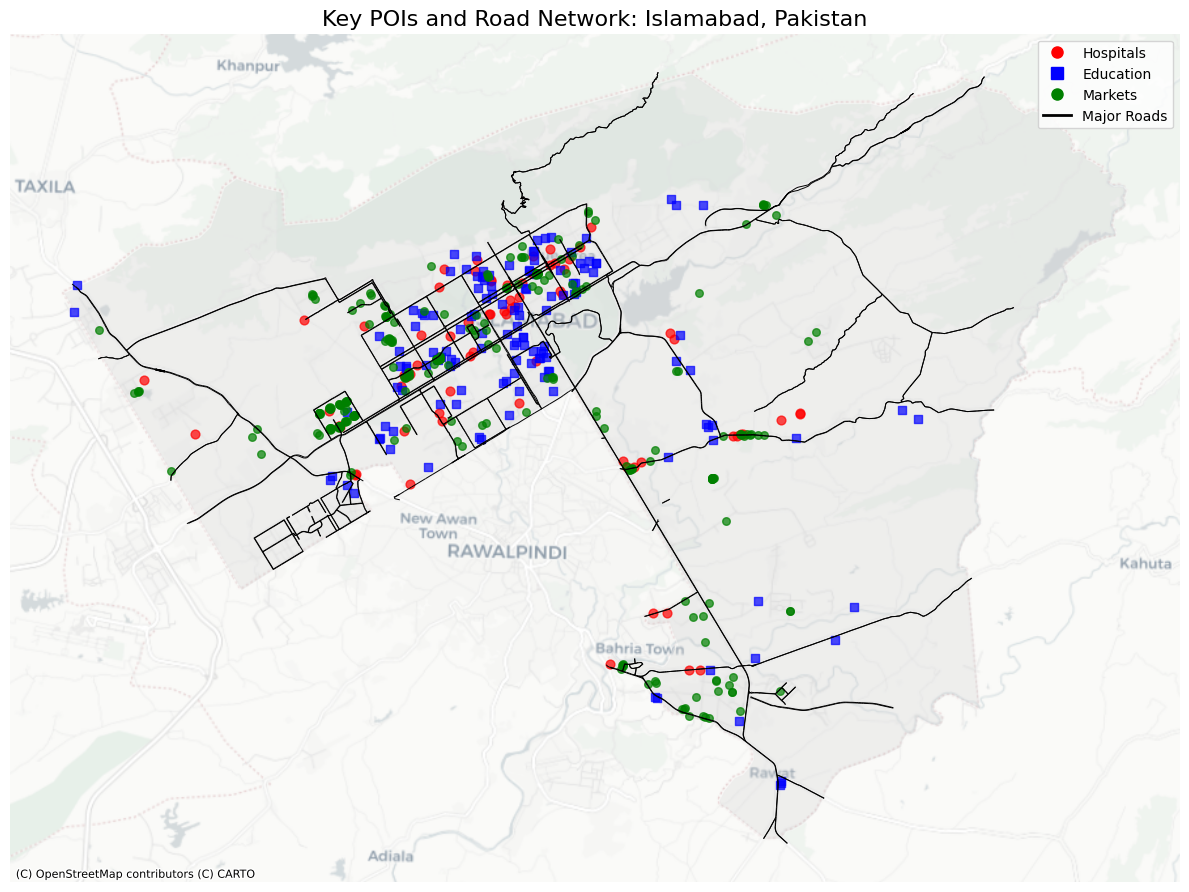


- Hospitals: 75
- Educations: 139
- Markets: 273
- Total POIs: 487
- Road Network: 96504 edges



In [8]:

fig, ax = plt.subplots(figsize=(12, 10))


boundary.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.3)
major_roads.plot(ax=ax, color='black', linewidth=0.7)


poi_colors = {'hospital': 'red', 'education': 'blue', 'market': 'green'}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois['type'] == ptype]
    subset.plot(ax=ax, color=color, markersize=30 + 10*(ptype == 'hospital'), 
               alpha=0.7, marker='o' if ptype != 'education' else 's')

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color='red', lw=0, marker='o', markersize=8, label='Hospitals'),
    Line2D([0], [0], color='blue', lw=0, marker='s', markersize=8, label='Education'),
    Line2D([0], [0], color='green', lw=0, marker='o', markersize=8, label='Markets'),
    Line2D([0], [0], color='black', lw=2, label='Major Roads')
]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title(f"Key POIs and Road Network: {place}", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.savefig('islamabad_pois_network.png', dpi=300)
plt.show()

print("\n" + "="*50)

for ptype in all_pois['type'].unique():
    count = (all_pois['type'] == ptype).sum()
    print(f"- {ptype.capitalize()}s: {count}")

print(f"- Total POIs: {len(all_pois)}")
print(f"- Road Network: {len(edges)} edges")
print("="*50 + "\n")

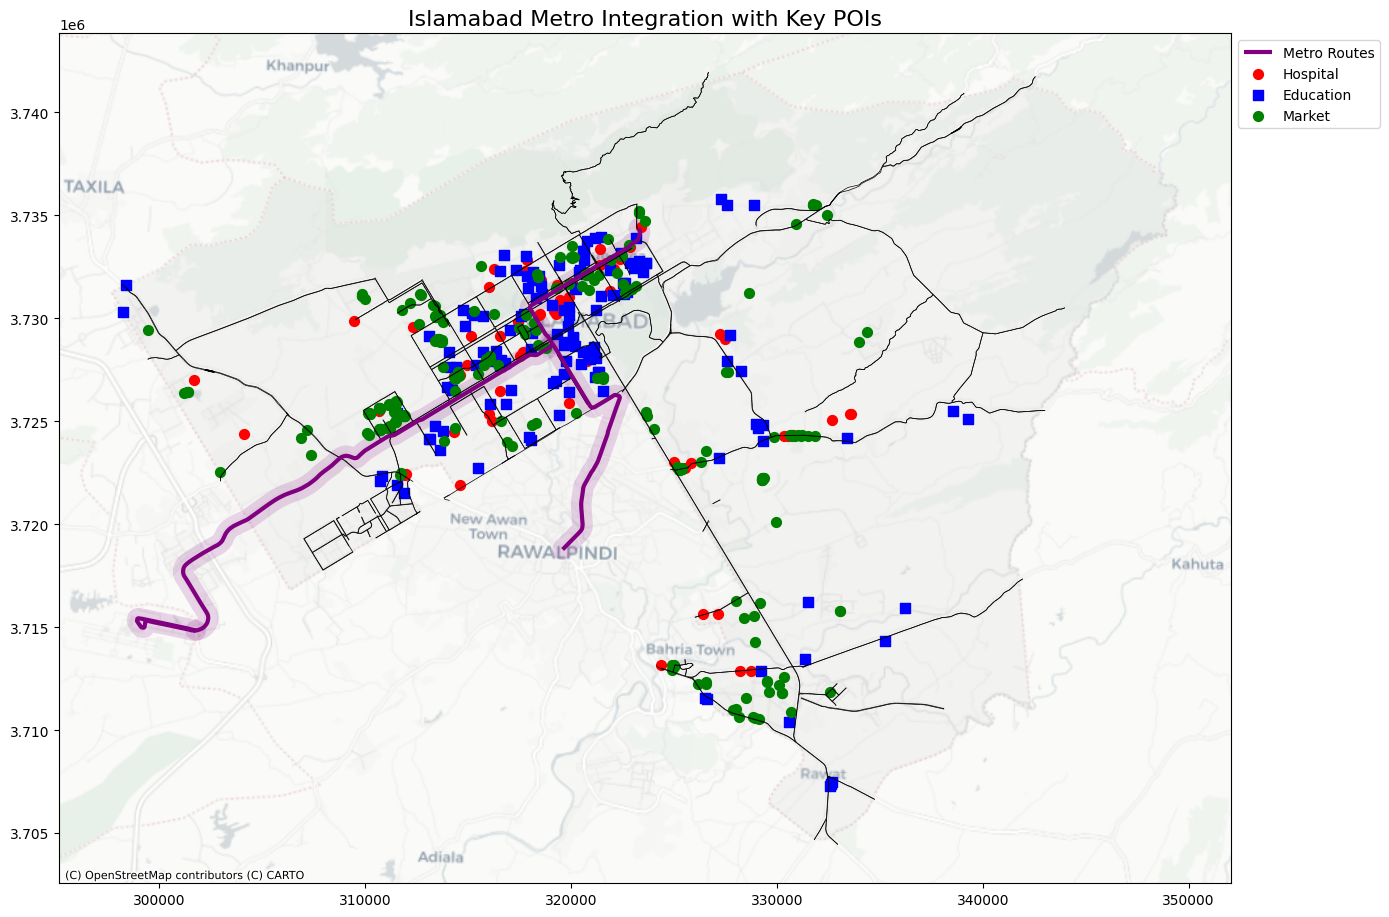

In [9]:
fig, ax = plt.subplots(figsize=(14, 12))

boundary.plot(ax=ax, color='lightgray', alpha=0.2)
major_roads.plot(ax=ax, color='black', linewidth=0.5)

metro_routes.plot(ax=ax, color='purple', linewidth=3, label='Metro Routes')
metro_service_areas.plot(ax=ax, color='purple', alpha=0.15, label='500m Service Area')

poi_colors = {'hospital':'red', 'education':'blue', 'market':'green'}
for ptype, color in poi_colors.items():
    all_pois[all_pois['type']==ptype].plot(
        ax=ax, color=color, markersize=50, marker='o' if ptype!='education' else 's',
        label=ptype.capitalize()
    )

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Islamabad Metro Integration with Key POIs", fontsize=16)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('metro_integration.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
underserved_pois = all_pois[~all_pois.geometry.within(metro_service_areas.unary_union)]


population = population.to_crs(metro_service_areas.crs)

# 3. Calculate served vs unserved population
served_pop = population[population.geometry.within(metro_service_areas.unary_union)]
unserved_pop = population[~population.geometry.within(metro_service_areas.unary_union)]

# 4. Print metrics

print(f"""
Metro Accessibility Report:
- POIs served: {len(all_pois) - len(underserved_pois)}/{len(all_pois)} 
  ({len(underserved_pois)} underserved)
- Population served: {served_pop['population'].sum():,.0f} 
  ({unserved_pop['population'].sum():,.0f} unserved)
- Key underserved areas:
  {underserved_pois.groupby('type').size().to_dict()}
""")




Metro Accessibility Report:
- POIs served: 88/487 
  (399 underserved)
- Population served: 162,042 
  (1,871,057 unserved)
- Key underserved areas:
  {'education': 118, 'hospital': 60, 'market': 221}



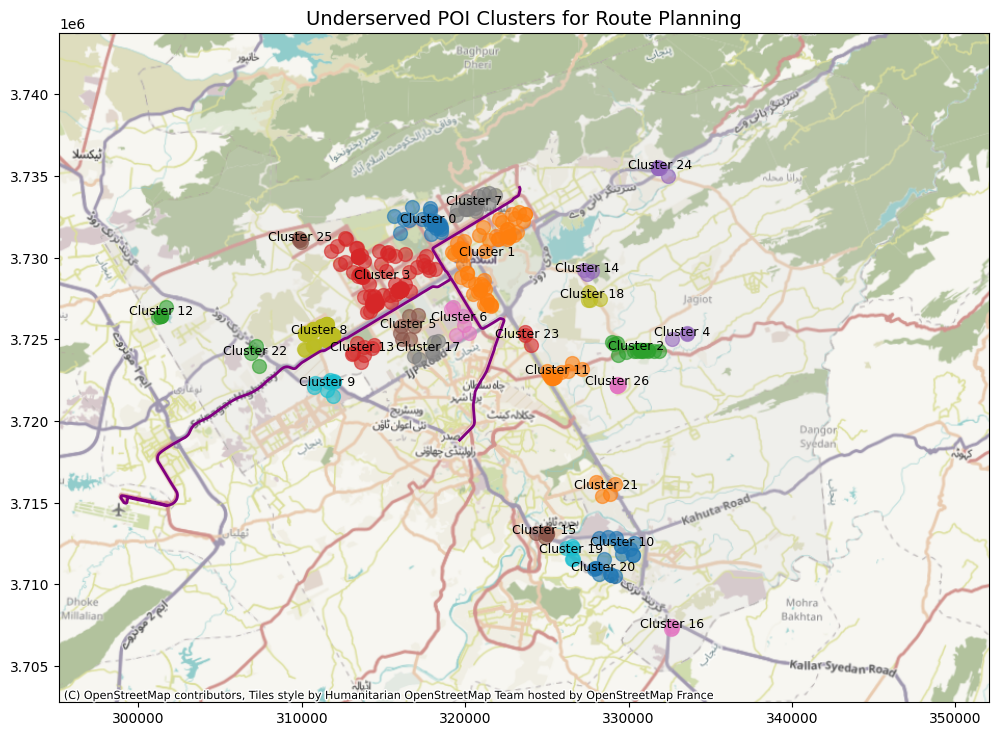

In [11]:
from sklearn.cluster import DBSCAN

# Cluster underserved POIs to identify demand hotspots
coords = np.array([[p.x, p.y] for p in underserved_pois.geometry])
db = DBSCAN(eps=1000, min_samples=3).fit(coords)  # 1km radius, min 3 POIs

underserved_pois['cluster'] = db.labels_
valid_clusters = underserved_pois[underserved_pois['cluster'] != -1]

# Visualize clusters
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color='lightgray', alpha=0.2)
metro_routes.plot(ax=ax, color='purple', linewidth=2)

for cluster_id in valid_clusters['cluster'].unique():
    cluster = valid_clusters[valid_clusters['cluster'] == cluster_id]
    cluster.plot(ax=ax, markersize=100, alpha=0.6)
    ax.annotate(
        f"Cluster {cluster_id}", 
        (cluster.geometry.centroid.x.mean(), cluster.geometry.centroid.y.mean()),
        fontsize=9, ha='center'
    )

ctx.add_basemap(ax, crs=utm_crs)
plt.title("Underserved POI Clusters for Route Planning", fontsize=14)
plt.show()

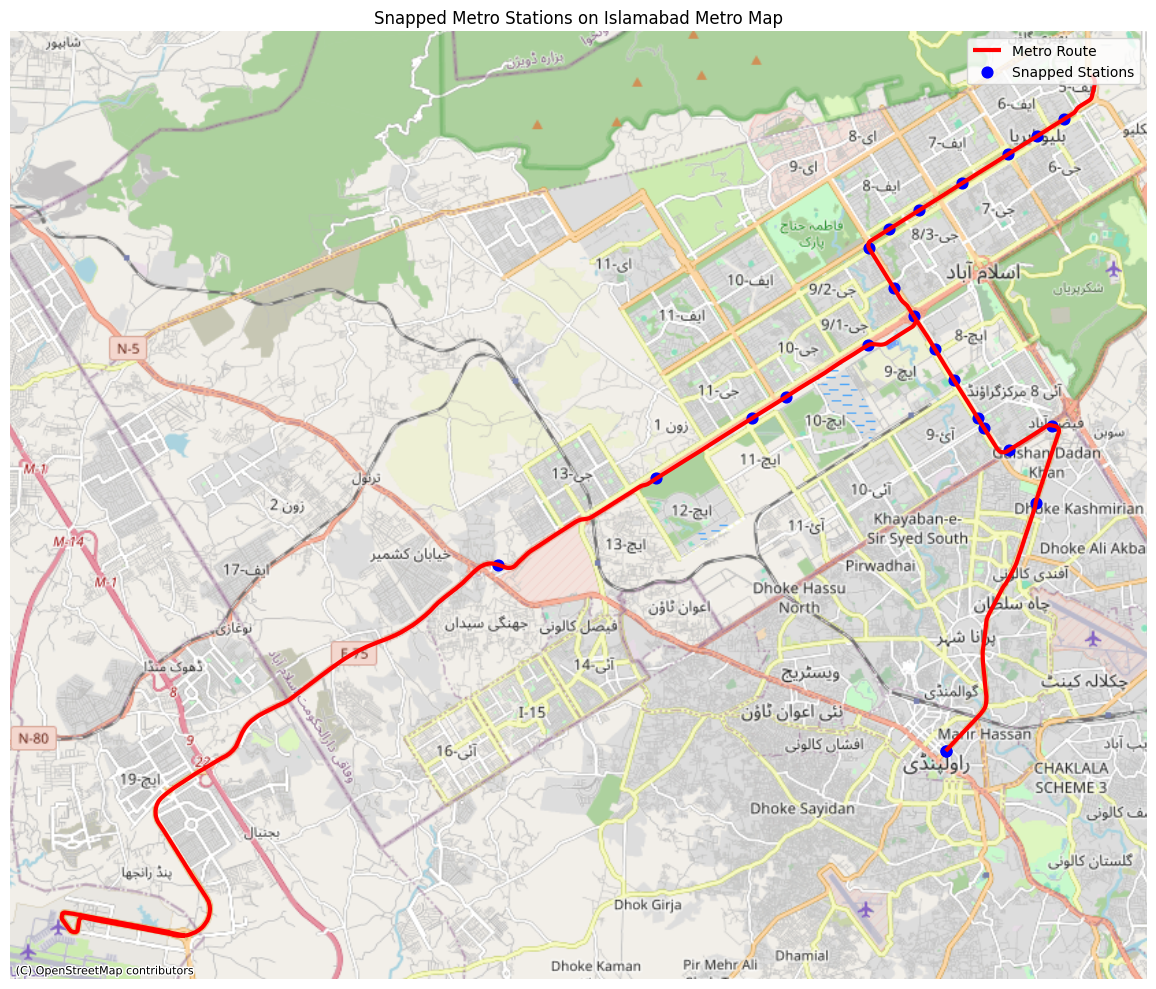

In [13]:
metro = gpd.read_file("metro-data/islamabad_sections.geojson").to_crs("EPSG:4326")

# Combine all metro lines into a single MultiLineString
metro_line = metro.unary_union


stations= gpd.read_file("preprocessedData/snapped_stations.gpkg")

stations_proj = stations.to_crs(epsg=3857)
metro_proj = metro.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))
metro_proj.plot(ax=ax, linewidth=3, color='red', label='Metro Route')
stations_proj.plot(ax=ax, color='blue', markersize=60, label='Snapped Stations')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Snapped Metro Stations on Islamabad Metro Map")
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def check_crs(gdf, expected_crs, name):
    """
    Ensures a GeoDataFrame has the expected CRS. If not, reprojects or sets it.

    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        The GeoDataFrame to check or reproject.
    expected_crs : str or pyproj.CRS
        The expected coordinate reference system (CRS).
    name : str
        A label for the GeoDataFrame, used in warning messages.

    Returns
    -------
    geopandas.GeoDataFrame
        The GeoDataFrame with the correct CRS.
    """
    if gdf.crs is None or gdf.crs != expected_crs:
        print(f"Warning: {name} CRS ({gdf.crs}) does not match expected ({expected_crs}). Reprojecting.")
        gdf = gdf.set_crs(expected_crs, allow_override=True) if gdf.crs is None else gdf.to_crs(expected_crs)
    return gdf


def validate_geometries(gdf, name):
    """
    Removes invalid or empty geometries from a GeoDataFrame.

    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        The GeoDataFrame to validate.
    name : str
        A label for the GeoDataFrame, used in warning messages.

    Returns
    -------
    geopandas.GeoDataFrame
        The GeoDataFrame with only valid, non-empty geometries.
    """
    invalid = gdf[~gdf.geometry.is_valid | gdf.geometry.is_empty]
    if not invalid.empty:
        print(f"Warning: {len(invalid)} invalid/empty geometries in {name}. Removing them.")
        gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty].copy()
    return gdf


unserved_pop = check_crs(unserved_pop, utm_crs, "unserved_pop")
boundary = check_crs(boundary, utm_crs, "boundary")
underserved_pois = check_crs(underserved_pois, utm_crs, "underserved_pois")
metro_routes = check_crs(metro_routes, utm_crs, "metro_routes")
stations_gdf = check_crs(stations.to_crs(utm_crs), utm_crs, "stations_gdf")
metro_service_areas = check_crs(metro_service_areas, utm_crs, "metro_service_areas")

unserved_pop = validate_geometries(unserved_pop, "unserved_pop")
boundary = validate_geometries(boundary, "boundary")
underserved_pois = validate_geometries(underserved_pois, "underserved_pois")
metro_routes = validate_geometries(metro_routes, "metro_routes")
stations_gdf = validate_geometries(stations_gdf, "stations_gdf")
metro_service_areas = validate_geometries(metro_service_areas, "metro_service_areas")

#  20km buffer around metro routes
metro_buffer_20km = metro_routes.copy()
metro_buffer_20km['geometry'] = metro_buffer_20km.geometry.buffer(20000)  # 20km
metro_buffer_20km = gpd.GeoDataFrame(metro_buffer_20km, geometry='geometry', crs=utm_crs)
metro_buffer_20km = validate_geometries(metro_buffer_20km, "metro_buffer_20km")

# unserved population and underserved POIs within 20km buffer
unserved_pop_buffer = gpd.sjoin(
    unserved_pop, metro_buffer_20km[['geometry']],
    how='inner', predicate='within'
)
underserved_pois_buffer = gpd.sjoin(
    underserved_pois, metro_buffer_20km[['geometry']],
    how='inner', predicate='within'
)

underserved_pois_buffer['distance_to_metro'] = underserved_pois_buffer.geometry.apply(
    lambda geom: metro_routes.unary_union.distance(geom)
)
def categorize_distance(dist):
    if dist < 1000:
        return '<1km'
    elif dist < 2000:
        return '1-2km'
    else:
        return '>2km'

underserved_pois_buffer['distance_cat'] = underserved_pois_buffer['distance_to_metro'].apply(categorize_distance)

total_population = unserved_pop_buffer['population'].sum()
avg_density = unserved_pop_buffer['population'].mean()
max_density = unserved_pop_buffer['population'].max()
high_density_count = len(unserved_pop_buffer[unserved_pop_buffer['population'] > 1000])

print("\n=== Analysis Summary ===")
print(f"Total Unserved Population within 20km Buffer: {total_population:.0f}")
print("Underserved POIs within 20km Buffer by Type:")
print(underserved_pois_buffer['type'].value_counts().to_string() if not underserved_pois_buffer.empty else "None")
print("\nUnderserved POIs by Distance to Metro Route:")
print(underserved_pois_buffer['distance_cat'].value_counts().to_string() if not underserved_pois_buffer.empty else "None")
print(f"Average Population Density (Unserved): {avg_density:.2f} people/km²")
print(f"Maximum Population Density (Unserved): {max_density:.2f} people/km²")
print(f"High-Density Cells (>1000 people/km²): {high_density_count}")
print("======================\n")


=== Analysis Summary ===
Total Unserved Population within 20km Buffer: 7036322
Underserved POIs within 20km Buffer by Type:
type
market       970
education    480
hospital     260

Underserved POIs by Distance to Metro Route:
distance_cat
>2km     748
1-2km    485
<1km     477
Average Population Density (Unserved): 1625.39 people/km²
Maximum Population Density (Unserved): 7986.94 people/km²
High-Density Cells (>1000 people/km²): 2249



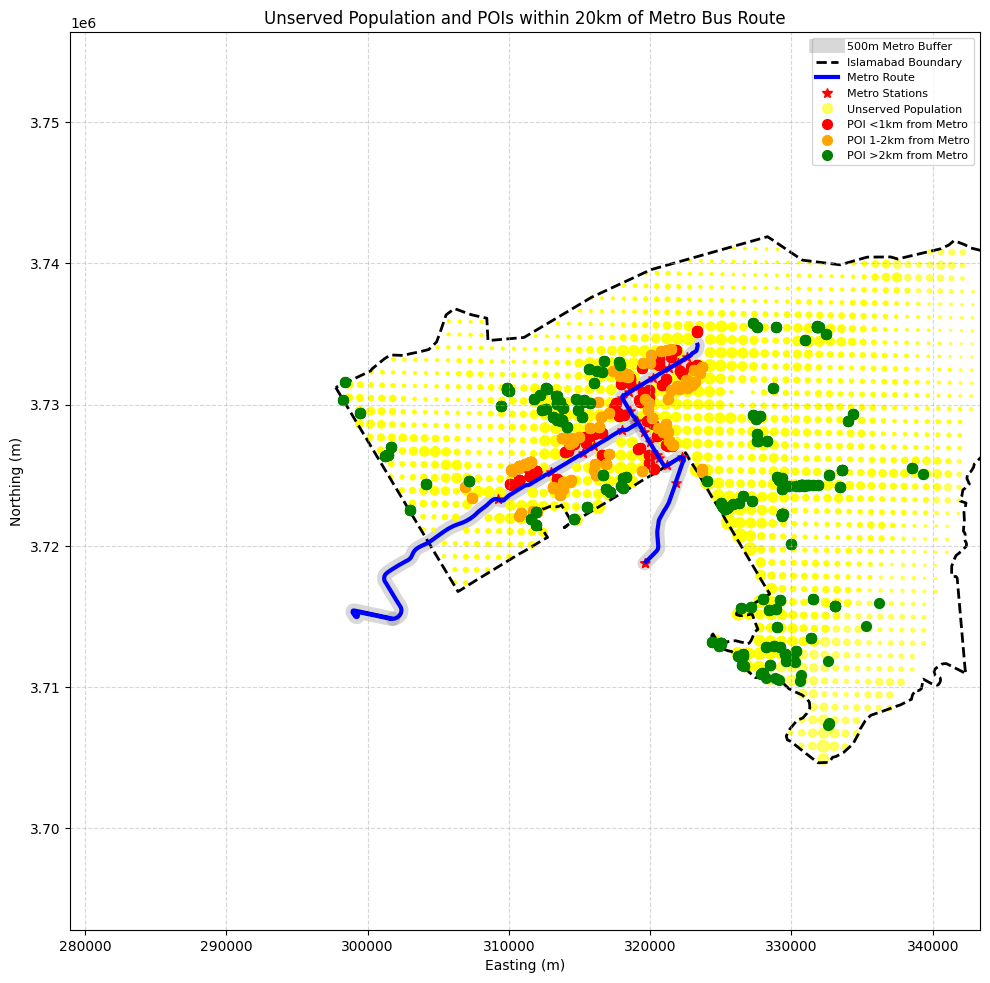

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


fig, ax = plt.subplots(figsize=(10, 10))

metro_service_areas.plot(ax=ax, facecolor='gray', alpha=0.3, label='500m Metro Buffer')

if not unserved_pop_buffer.empty:
    unserved_pop_buffer.plot(
        ax=ax,
        column='population',
        markersize=unserved_pop_buffer['population'] / unserved_pop_buffer['population'].max() * 100,
        color='yellow',
        alpha=0.6,
        label='Unserved Population'
    )

boundary.plot(ax=ax, edgecolor='black', linestyle='--', facecolor='none', linewidth=2, label='Islamabad Boundary')

metro_routes.plot(ax=ax, color='blue', linewidth=3, label='Metro Route')

distance_colors = {'<1km': 'red', '1-2km': 'orange', '>2km': 'green'}
distance_labels = {'<1km': 'POI <1km', '1-2km': 'POI 1-2km', '>2km': 'POI >2km'}
for dist_cat in distance_colors:
    subset = underserved_pois_buffer[underserved_pois_buffer['distance_cat'] == dist_cat]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=distance_colors[dist_cat],
            marker='o',
            markersize=50,
            label=distance_labels[dist_cat]
        )

stations_gdf.plot(ax=ax, color='red', marker='*', markersize=50, label='Metro Stations')

ax.set_title('Unserved Population and POIs within 20km of Metro Bus Route', fontsize=12)
ax.set_xlabel('Easting (m)', fontsize=10)
ax.set_ylabel('Northing (m)', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal')

legend_elements = [
    Line2D([0], [0], color='gray', lw=10, alpha=0.3, label='500m Metro Buffer'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='Islamabad Boundary'),
    Line2D([0], [0], color='blue', lw=3, label='Metro Route'),
    Line2D([0], [0], marker='*', color='red', linestyle='none', markersize=7, label='Metro Stations'),
    Line2D([0], [0], marker='o', color='yellow', linestyle='none', markersize=7, alpha=0.6, label='Unserved Population'),
    Line2D([0], [0], marker='o', color='red', linestyle='none', markersize=7, label='POI <1km from Metro'),
    Line2D([0], [0], marker='o', color='orange', linestyle='none', markersize=7, label='POI 1-2km from Metro'),
    Line2D([0], [0], marker='o', color='green', linestyle='none', markersize=7, label='POI >2km from Metro')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

minx, miny, maxx, maxy = metro_buffer_20km.total_bounds
ax.set_xlim(minx , maxx )
ax.set_ylim(miny - 2000, maxy + 2000)

plt.subplots_adjust(left=0.6, right=1.2, top=0.9, bottom=0.1)

plt.tight_layout()

plt.show()


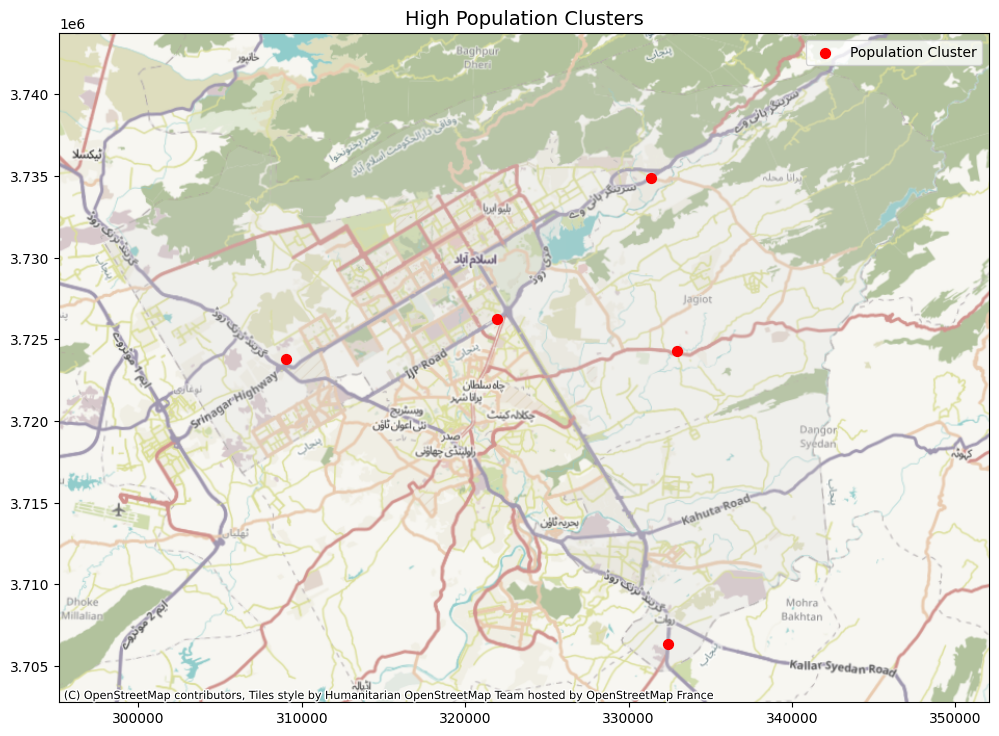

In [16]:

population_utm = population.to_crs(utm_crs)
dense_pop = population_utm[population_utm['population'] > 3000].copy()

pop_coords = np.array([[pt.x, pt.y] for pt in dense_pop.geometry])

db_pop = DBSCAN(eps=2000, min_samples=2, metric='euclidean').fit(pop_coords)
dense_pop['cluster'] = db_pop.labels_

valid_pop_clusters = dense_pop[dense_pop['cluster'] != -1].copy()

# The center of a spatially clustered group of high-population cells.
pop_cluster_centroids = (
    valid_pop_clusters
    .dissolve(by='cluster', as_index=False)
    .centroid
    .to_frame(name='geometry')
)
pop_cluster_centroids = gpd.GeoDataFrame(pop_cluster_centroids, crs=population.crs)
pop_cluster_centroids['type'] = 'population'

boundary_utm = boundary.to_crs(utm_crs)
pop_cluster_centroids_utm = pop_cluster_centroids.to_crs(utm_crs)

fig, ax = plt.subplots(figsize=(12, 10))
boundary_utm.plot(ax=ax, color='lightgray', alpha=0.2)
pop_cluster_centroids_utm.plot(ax=ax, color='red', markersize=50, label='Population Cluster')
ctx.add_basemap(ax, crs=utm_crs)
plt.title("High Population Clusters", fontsize=14)
plt.legend()
plt.show()


In [17]:
pop_cluster_centroids_utm = pop_cluster_centroids.to_crs(utm_crs)
metro_utm = metro.to_crs(utm_crs)


metro_line_utm = metro_utm.unary_union

buffer_1km = gpd.GeoSeries(metro_line_utm).buffer(1000).unary_union
buffer_10km = gpd.GeoSeries(metro_line_utm).buffer(15000).unary_union

within_10km = pop_cluster_centroids_utm.geometry.within(buffer_10km)
outside_1km = ~pop_cluster_centroids_utm.geometry.within(buffer_1km)

pop_cluster_centroids = pop_cluster_centroids_utm[within_10km & outside_1km].copy()


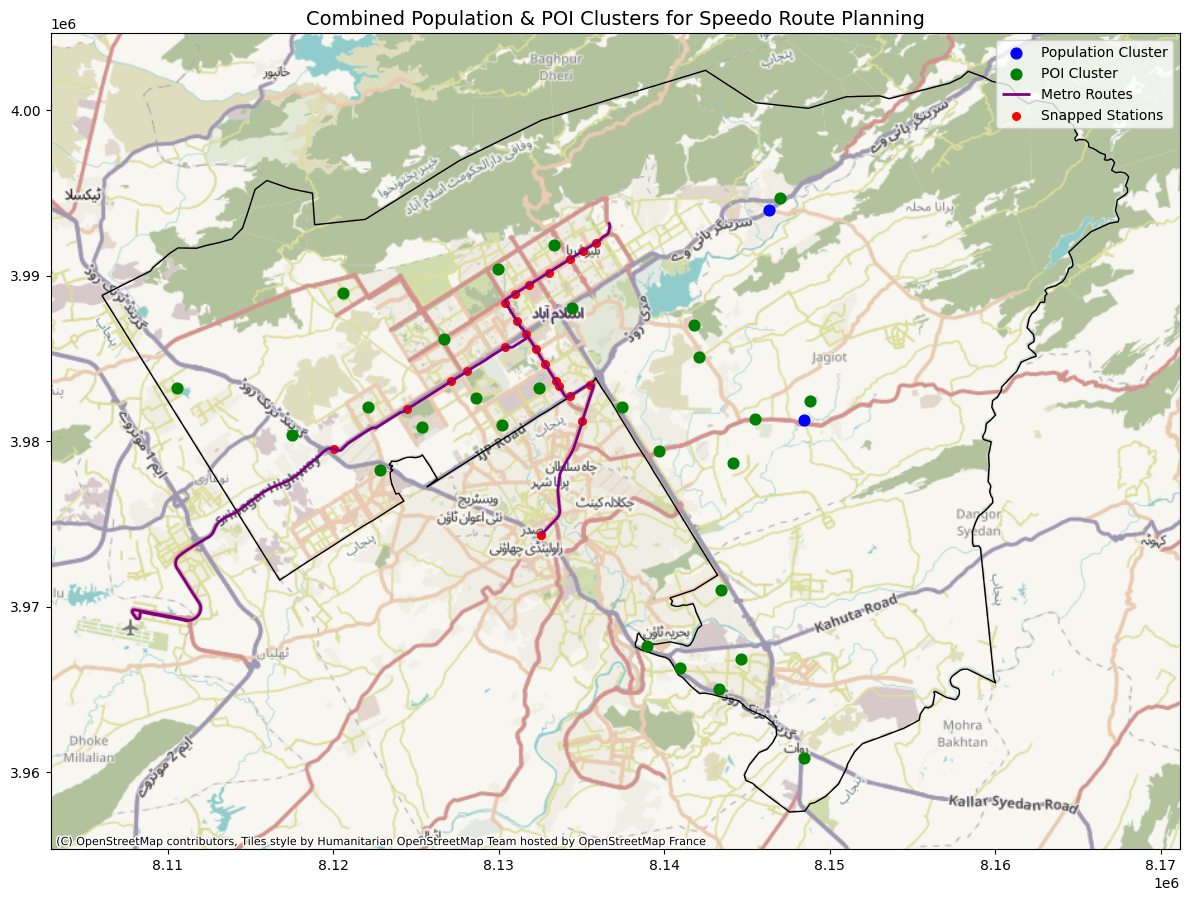

In [18]:

valid_clusters = valid_clusters.to_crs(epsg=3857)

poi_clusters_dissolved = valid_clusters.dissolve(by='cluster', as_index=False)
poi_cluster_centroids = poi_clusters_dissolved.copy()
poi_cluster_centroids['geometry'] = poi_clusters_dissolved.centroid

poi_cluster_centroids = gpd.GeoDataFrame(poi_cluster_centroids, geometry='geometry')
poi_cluster_centroids.set_crs(epsg=3857, inplace=True, allow_override=True)
poi_cluster_centroids['type'] = 'poi'

pop_cluster_centroids = pop_cluster_centroids.to_crs(utm_crs)
poi_cluster_centroids = poi_cluster_centroids.to_crs(utm_crs)
combined_clusters = gpd.GeoDataFrame(
    pd.concat([pop_cluster_centroids, poi_cluster_centroids], ignore_index=True),
    crs=utm_crs
)

combined_clusters_web = combined_clusters.to_crs(epsg=3857)
boundary_web = boundary.to_crs(epsg=3857)
metro_routes_web= metro_routes.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))
boundary_web.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
combined_clusters_web[combined_clusters_web['type'] == 'population']\
    .plot(ax=ax, color='blue', markersize=60, label='Population Cluster')
combined_clusters_web[combined_clusters_web['type'] == 'poi']\
    .plot(ax=ax, color='green', markersize=60, label='POI Cluster')
metro_routes_web.plot(ax=ax, color='purple', linewidth=2, label='Metro Routes')
stations_proj.plot(ax=ax, color='red', markersize=30, label='Snapped Stations')
ctx.add_basemap(ax, crs=combined_clusters_web.crs)
plt.title("Combined Population & POI Clusters for Speedo Route Planning", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:

pop_clusters = combined_clusters_web[combined_clusters_web['type'] == 'population'].copy()
poi_clusters = combined_clusters_web[combined_clusters_web['type'] == 'poi'].copy()

connections = []

for i, pop_row in pop_clusters.iterrows():
    pop_point = pop_row.geometry
    
    poi_clusters['dist'] = poi_clusters.geometry.distance(pop_point)
    
    nearest_poi = poi_clusters.loc[poi_clusters['dist'].idxmin()]
    
    connections.append({
        'pop_index': i,
        'poi_index': nearest_poi.name,
        'pop_geometry': pop_point,
        'poi_geometry': nearest_poi.geometry,
        'distance': nearest_poi['dist']
    })

connection_lines = gpd.GeoDataFrame(
    connections,
    geometry=[LineString([c['pop_geometry'], c['poi_geometry']]) for c in connections],
    crs=combined_clusters_web.crs
)


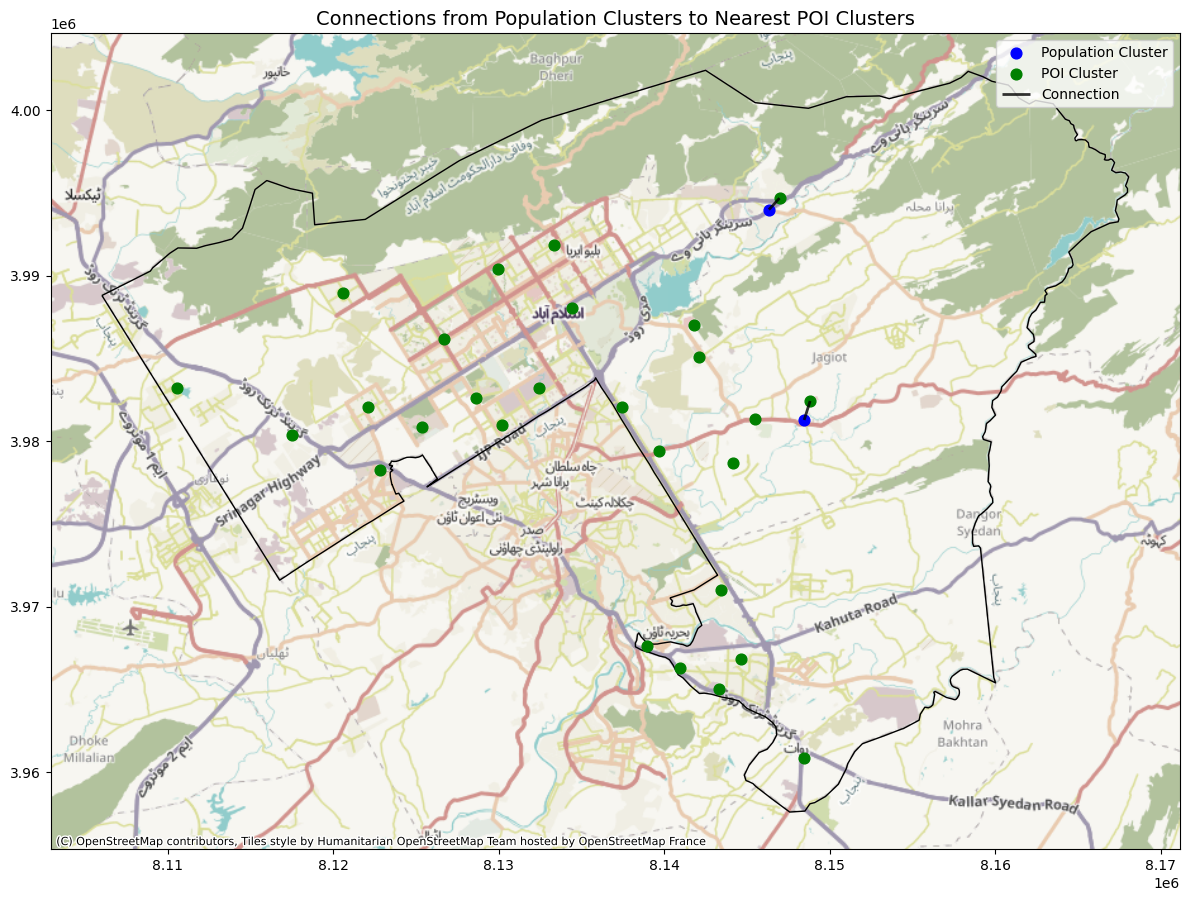

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))

boundary_web.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)


pop_clusters.plot(ax=ax, color='blue', markersize=60, label='Population Cluster')

poi_clusters.plot(ax=ax, color='green', markersize=60, label='POI Cluster')

connection_lines.plot(ax=ax, color='black', linewidth=2, alpha=0.8, label='Connection')

ctx.add_basemap(ax, crs=connection_lines.crs)

plt.title("Connections from Population Clusters to Nearest POI Clusters", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
